In [24]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical


In [25]:
dataPath='static/dataset_new/train'

In [26]:
def load_images_from_folder(folder):
    IMG_SIZE = 145
    images = []
    labels = []
    for label in ["closed", "open", "yawn", "no_yawn"]:
        path = os.path.join(folder, label)
        class_num = ["closed", "open", "yawn", "no_yawn"].index(label)
        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize image
                images.append(img)
                labels.append(class_num)
    return np.array(images), np.array(labels)

images, labels = load_images_from_folder(dataPath)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape the data
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Convert labels to categorical
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)


In [28]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [29]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145, 145, 1)))  # Input shape adjusted to (145, 145, 1)
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 143, 143, 256)  │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 71, 71, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 69, 69, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,532 (1.87 MB)

 Trainable params: 490,532 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# EarlyStopping and ModelCheckpoint callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
mc = ModelCheckpoint('best_model4Cat.keras', monitor='val_accuracy', mode='max', verbose=1,save_best_only=True)

In [33]:
history = model.fit(train_generator, 
                    validation_data=(X_test, y_test), 
                    epochs=50, 
                    callbacks=[es, mc])

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7834 - loss: 0.3993
Epoch 1: val_accuracy improved from -inf to 0.78340, saving model to best_model4Cat.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7835 - loss: 0.3993 - val_accuracy: 0.7834 - val_loss: 0.3341
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7975 - loss: 0.3719
Epoch 2: val_accuracy improved from 0.78340 to 0.80567, saving model to best_model4Cat.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7975 - loss: 0.3719 - val_accuracy: 0.8057 - val_loss: 0.3577
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8000 - loss: 0.3689
Epoch 3: val_accuracy improved from 0.80567 to 0.84008, saving model to best_model4Cat.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8000 - loss: 0.3689 - val_accuracy: 0.8401 - val_loss: 0.3182
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7935 - loss: 0.3683
Epoch 4: val_accuracy did not improve from 0.84

In [36]:
model.save('best-model4Cat.h5')

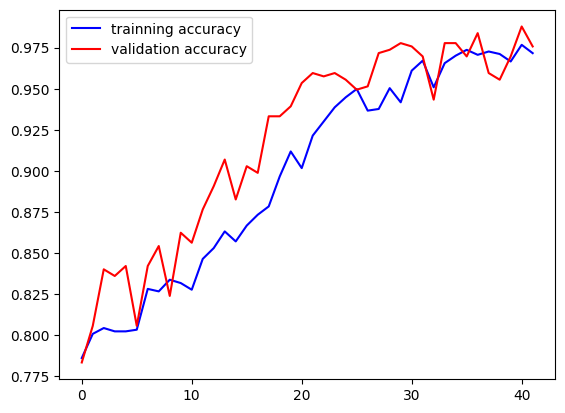

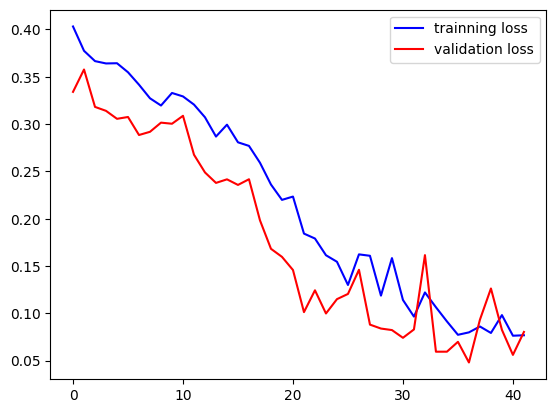

In [38]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [39]:
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (145, 145))  # Adjusted to the input shape
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    
    prediction = model.predict(img)
    class_idx = np.argmax(prediction)
    class_labels = ["closed", "open", "yawn", "no_yawn"]
    return class_labels[class_idx]

example_image_path = dataPath + "/yawn/718.jpg"
print(predict_image(example_image_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
yawn
